## German Text Classification
##### ZAKARYA ROUZKI
##### zakaryarouzki@gmail.com

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import sklearn
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
RANDOM_SEED = 42

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### 1. Download the Dataset

In [2]:
!git clone https://github.com/tblock/10kGNAD.git

Cloning into '10kGNAD'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 93 (delta 0), reused 2 (delta 0), pack-reused 88
Unpacking objects: 100% (93/93), done.


In [3]:
train = pd.read_csv('10kGNAD/train.csv', delimiter=';', quotechar='\'', quoting=csv.QUOTE_MINIMAL, names=['label', 'text'])
test = pd.read_csv('10kGNAD/test.csv', delimiter=';', quotechar='\'', quoting=csv.QUOTE_MINIMAL, names=['label', 'text'])
train['data_split'] = 'train'
test['data_split'] = 'test'
train.shape, test.shape

((9245, 3), (1028, 3))

In [4]:
##  concatenate the two datasets
all_data = pd.concat([train, test])
all_data.shape

(10273, 3)

In [5]:
## check null values
all_data.isnull().sum()

label         0
text          0
data_split    0
dtype: int64

In [6]:
## build corpus by concatenating all text rows
corpus = (' '.join(all_data['text']))

(-0.5, 999.5, 499.5, -0.5)

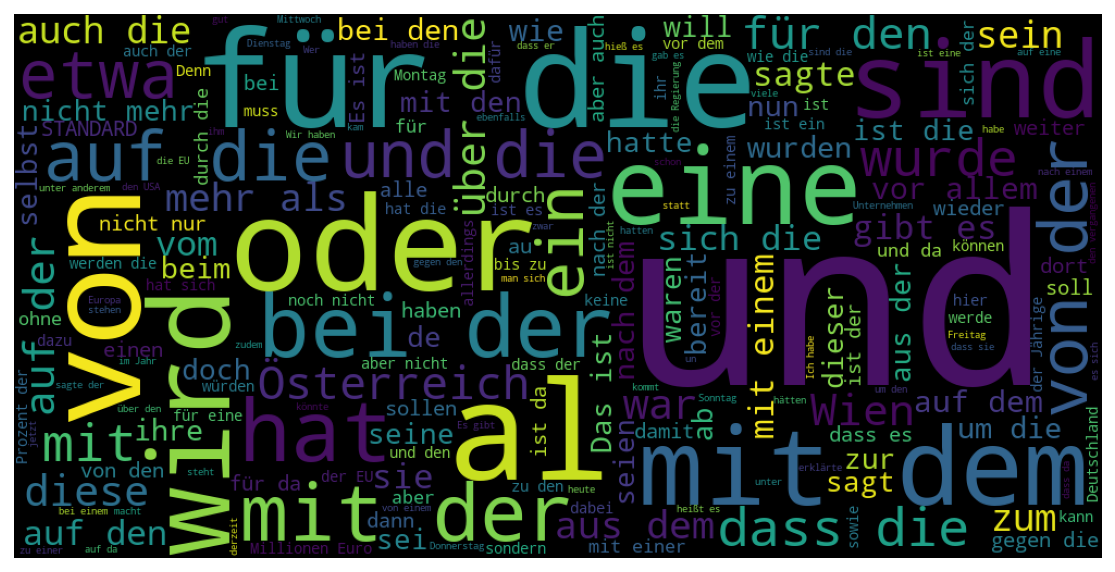

In [7]:
wordcloud = WordCloud(width = 1000, height = 500).generate(corpus)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')

In [8]:
# wordcloud.stopwords

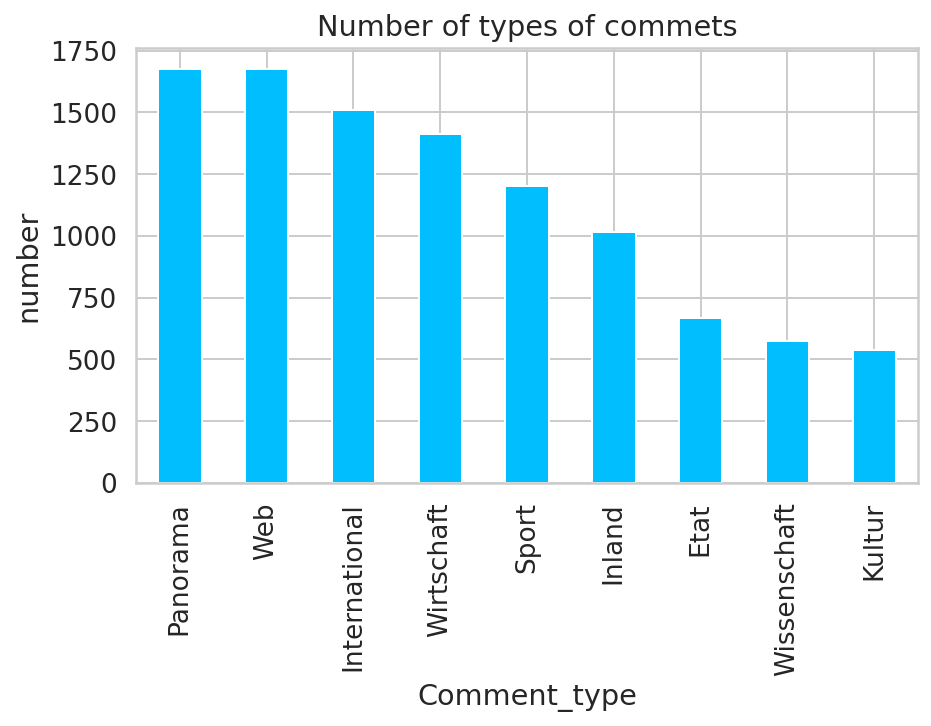

In [9]:
all_data['label'].value_counts().plot(kind='bar',figsize=(7,4));
plt.title('Number of types of commets');
plt.xlabel('Comment_type');
plt.ylabel('number');

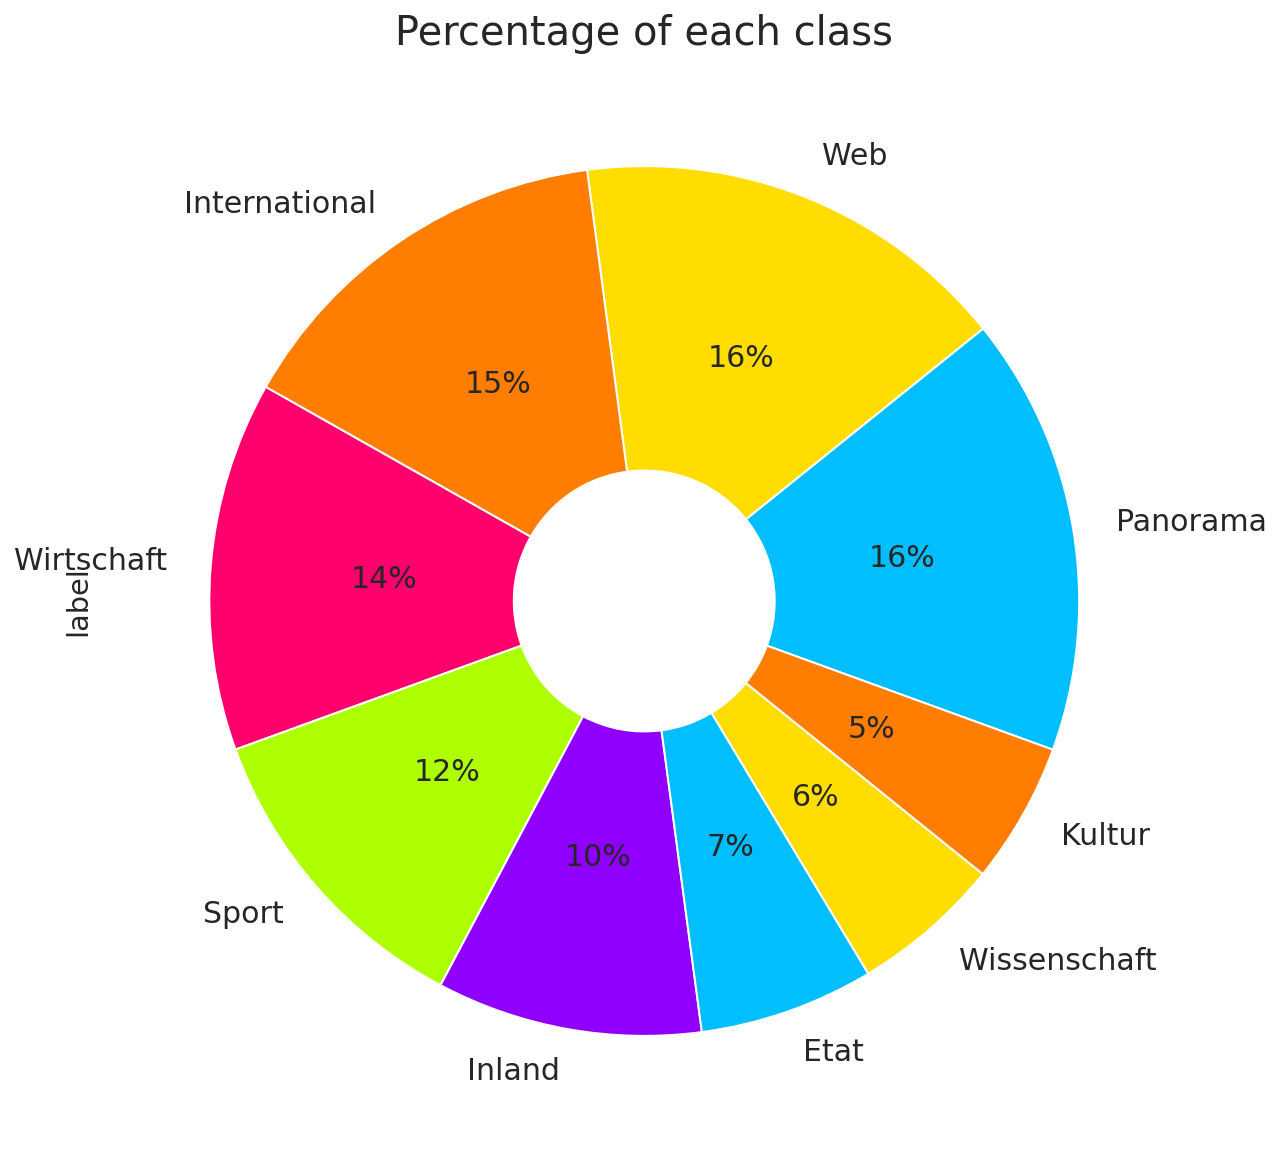

In [10]:
plt.figure(figsize=(30,10))
plt.title('Percentage of each class', fontsize=20)
train.label.value_counts().plot(kind='pie', labels=train.label.value_counts().keys(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

In [11]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

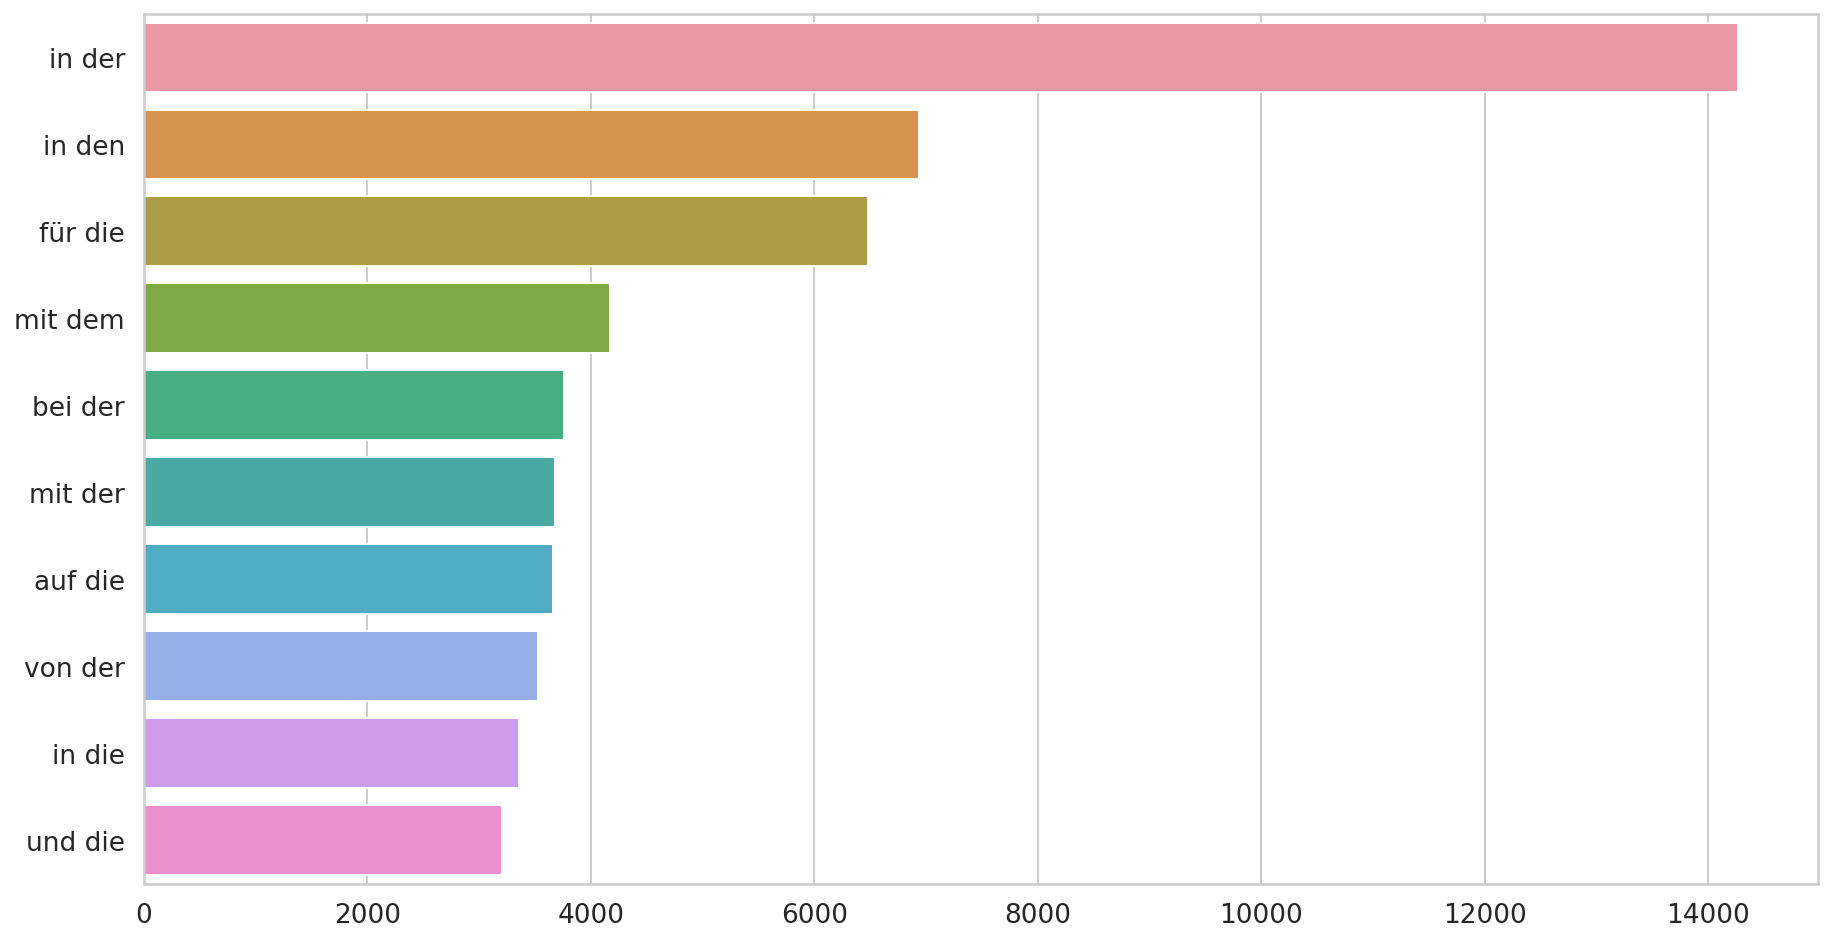

In [12]:
### 2-grams top plotting
top_n_bigrams= get_top_ngram(all_data['text'], 2)[:10] 
x, y = map(list,zip(*top_n_bigrams))
plt.figure(figsize=(15,8))
sns.barplot(x=y,y=x)

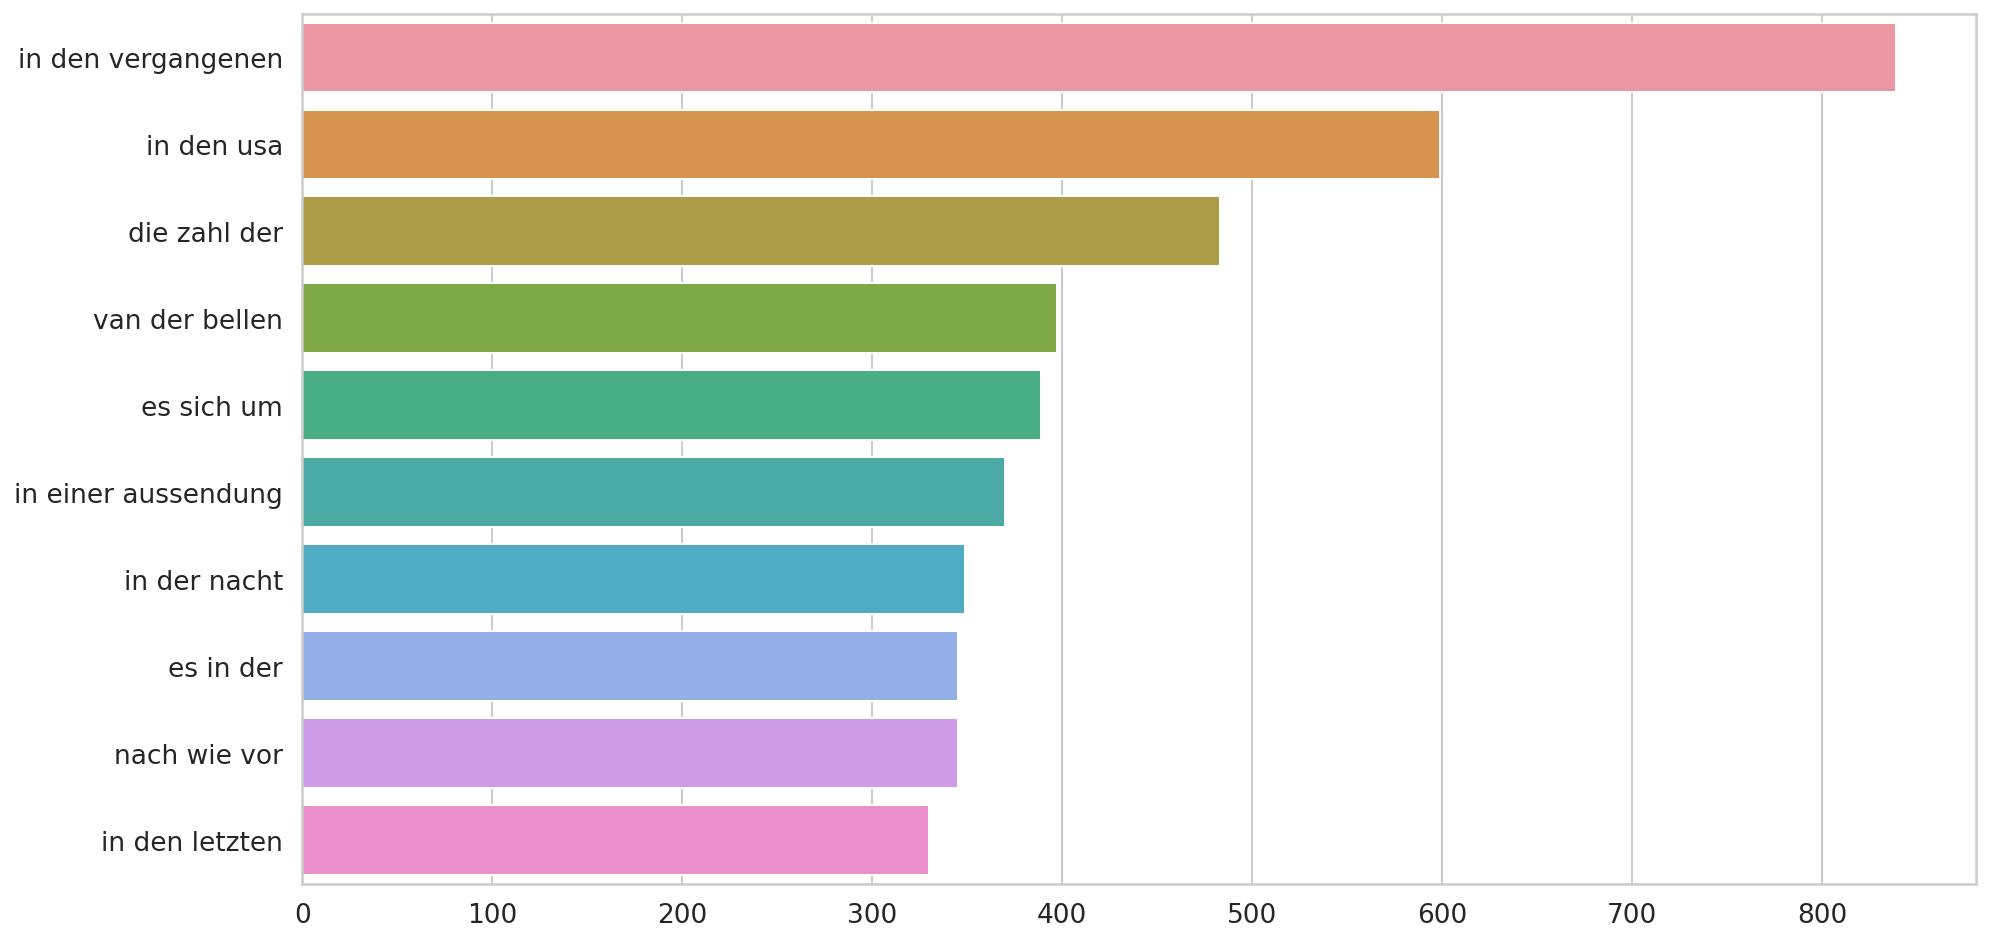

In [13]:
### 3-grams top plotting
top_n_bigrams= get_top_ngram(all_data['text'], 3)[:10] 
x, y = map(list,zip(*top_n_bigrams))
plt.figure(figsize=(15,8))
sns.barplot(x=y,y=x)

In [14]:
all_data['Num_word_text'] = all_data['text'].progress_apply(lambda x:len(str(x).split())) #Number Of words in main text

  0%|          | 0/10273 [00:00<?, ?it/s]

In [15]:
import plotly.figure_factory as ff

# Create distplot with custom bin_size
fig = ff.create_distplot([all_data['Num_word_text']], ['text'],show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

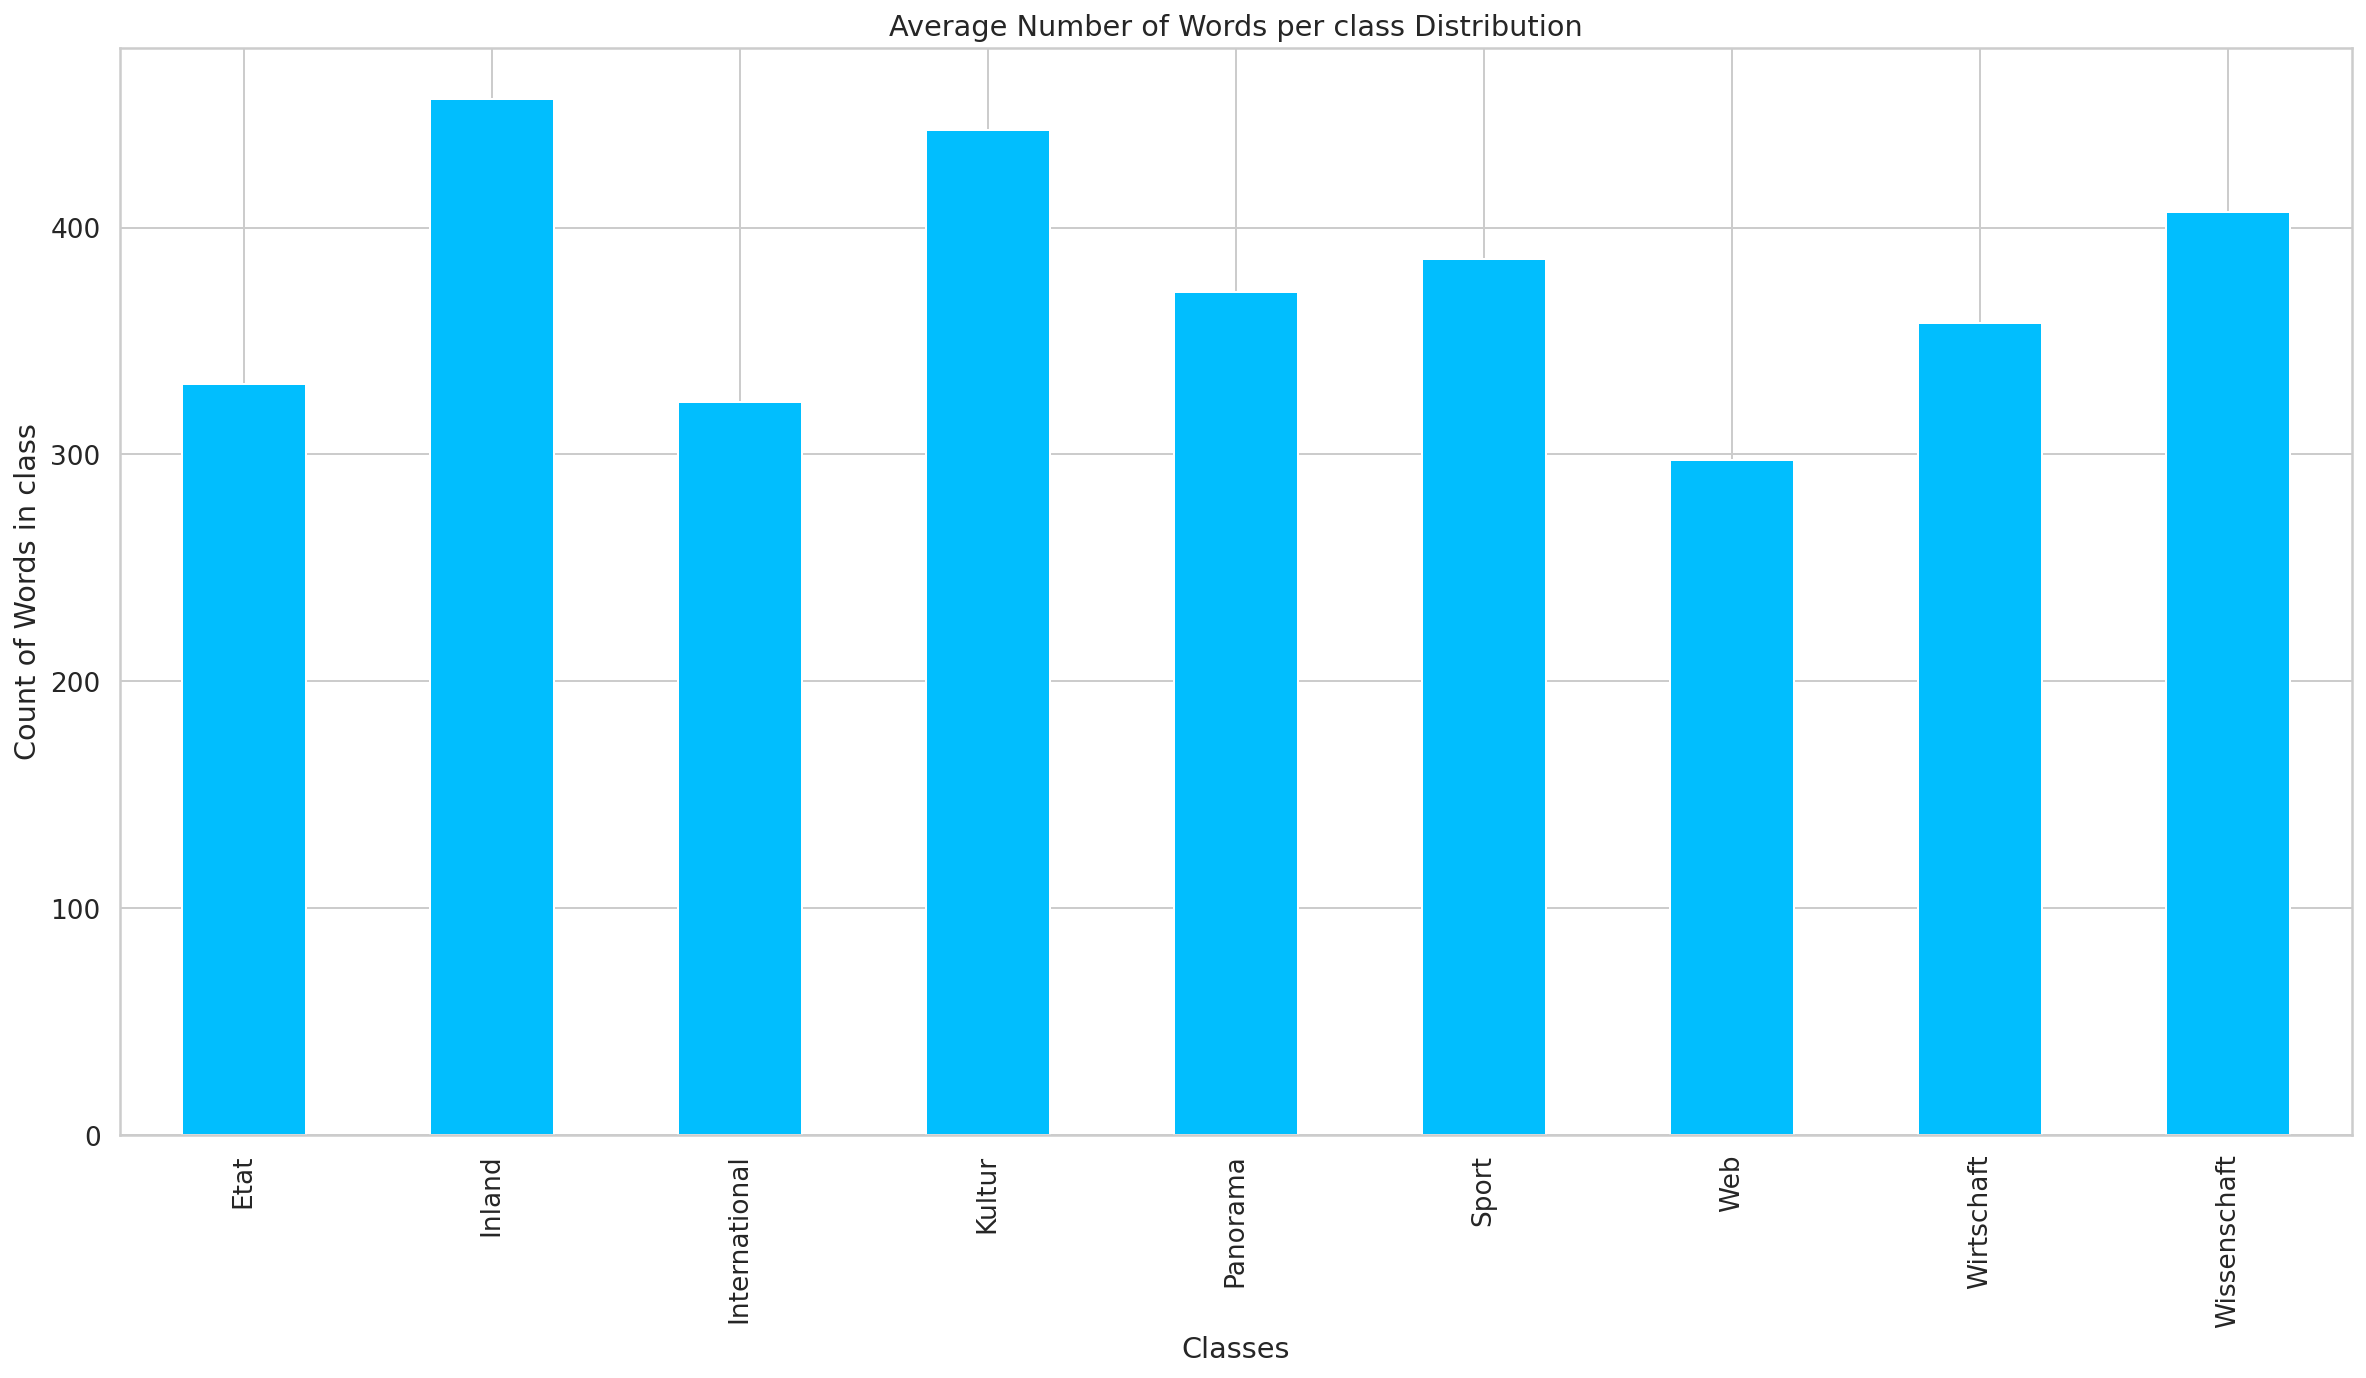

In [16]:
letter_avg = all_data.groupby('label')['Num_word_text'].mean().plot(kind='bar', figsize=(20, 10))
plt.xlabel('Classes')
plt.ylabel('Count of Words in class')
plt.title('Average Number of Words per class Distribution')
plt.show()

## Preprocessing

In [17]:
# !pip install fasttext

In [18]:
# import fasttext
# pretrained_model = "lid.176.bin" 
# model = fasttext.load_model(pretrained_model)
# langs = []
# for sent in train['text']:
#     lang = model.predict(sent)[0]
#     langs.append(str(lang)[11:13])
# train['langs'] = langs

In [19]:
# Tokenization
train['text_tokenized'] = train['text'].progress_apply(word_tokenize)
train.head()

  0%|          | 0/9245 [00:00<?, ?it/s]

,label,text,data_split,text_tokenized
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,train,"[21-Jähriger, fällt, wohl, bis, Saisonende, au..."
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",train,"[Erfundene, Bilder, zu, Filmen, ,, die, als, v..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,train,"[Der, frischgekürte, CEO, Sundar, Pichai, setz..."
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",train,"[Putin, :, ``, Einigung, ,, dass, wir, Menge, ..."
4,Inland,Estland sieht den künftigen österreichischen P...,train,"[Estland, sieht, den, künftigen, österreichisc..."


In [20]:
# Converting all Characters to Lowercase // ie: maybe not good because all nouns in german are capitalized so we may lost this info
train['lower'] = train['text_tokenized'].progress_apply(lambda x: [word.lower() for word in x])
train.head()

  0%|          | 0/9245 [00:00<?, ?it/s]

,label,text,data_split,text_tokenized,lower
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,train,"[21-Jähriger, fällt, wohl, bis, Saisonende, au...","[21-jähriger, fällt, wohl, bis, saisonende, au..."
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",train,"[Erfundene, Bilder, zu, Filmen, ,, die, als, v...","[erfundene, bilder, zu, filmen, ,, die, als, v..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,train,"[Der, frischgekürte, CEO, Sundar, Pichai, setz...","[der, frischgekürte, ceo, sundar, pichai, setz..."
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",train,"[Putin, :, ``, Einigung, ,, dass, wir, Menge, ...","[putin, :, ``, einigung, ,, dass, wir, menge, ..."
4,Inland,Estland sieht den künftigen österreichischen P...,train,"[Estland, sieht, den, künftigen, österreichisc...","[estland, sieht, den, künftigen, österreichisc..."


In [21]:
import string
# Removing Punctuations
punc = string.punctuation
train['no_punc'] = train['lower'].progress_apply(lambda x: [word for word in x if word not in punc])
train.head()

  0%|          | 0/9245 [00:00<?, ?it/s]

,label,text,data_split,text_tokenized,lower,no_punc
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,train,"[21-Jähriger, fällt, wohl, bis, Saisonende, au...","[21-jähriger, fällt, wohl, bis, saisonende, au...","[21-jähriger, fällt, wohl, bis, saisonende, au..."
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",train,"[Erfundene, Bilder, zu, Filmen, ,, die, als, v...","[erfundene, bilder, zu, filmen, ,, die, als, v...","[erfundene, bilder, zu, filmen, die, als, verl..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,train,"[Der, frischgekürte, CEO, Sundar, Pichai, setz...","[der, frischgekürte, ceo, sundar, pichai, setz...","[der, frischgekürte, ceo, sundar, pichai, setz..."
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",train,"[Putin, :, ``, Einigung, ,, dass, wir, Menge, ...","[putin, :, ``, einigung, ,, dass, wir, menge, ...","[putin, ``, einigung, dass, wir, menge, auf, n..."
4,Inland,Estland sieht den künftigen österreichischen P...,train,"[Estland, sieht, den, künftigen, österreichisc...","[estland, sieht, den, künftigen, österreichisc...","[estland, sieht, den, künftigen, österreichisc..."


In [22]:
# Removing Stopwords
stop_words = set(stopwords.words('german'))
train['stopwords_removed'] = train['no_punc'].progress_apply(lambda x: [word for word in x if word not in stop_words])
train.head()

  0%|          | 0/9245 [00:00<?, ?it/s]

,label,text,data_split,text_tokenized,lower,no_punc,stopwords_removed
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,train,"[21-Jähriger, fällt, wohl, bis, Saisonende, au...","[21-jähriger, fällt, wohl, bis, saisonende, au...","[21-jähriger, fällt, wohl, bis, saisonende, au...","[21-jähriger, fällt, wohl, saisonende, wien, –..."
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",train,"[Erfundene, Bilder, zu, Filmen, ,, die, als, v...","[erfundene, bilder, zu, filmen, ,, die, als, v...","[erfundene, bilder, zu, filmen, die, als, verl...","[erfundene, bilder, filmen, verloren, gelten, ..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,train,"[Der, frischgekürte, CEO, Sundar, Pichai, setz...","[der, frischgekürte, ceo, sundar, pichai, setz...","[der, frischgekürte, ceo, sundar, pichai, setz...","[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",train,"[Putin, :, ``, Einigung, ,, dass, wir, Menge, ...","[putin, :, ``, einigung, ,, dass, wir, menge, ...","[putin, ``, einigung, dass, wir, menge, auf, n...","[putin, ``, einigung, menge, niveau, jänner, h..."
4,Inland,Estland sieht den künftigen österreichischen P...,train,"[Estland, sieht, den, künftigen, österreichisc...","[estland, sieht, den, künftigen, österreichisc...","[estland, sieht, den, künftigen, österreichisc...","[estland, sieht, künftigen, österreichischen, ..."


In [23]:
## function to handle all above steps : cleaning


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    ## tokenize words
    word_tokens = word_tokenize(text)
    ## lower words
    words_tokens_lower = [word.lower() for word in word_tokens]

    
    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [24]:
train["cleaned_text"] = train["text"].progress_map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
)
test["cleaned_text"] = test["text"].progress_map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
)

  0%|          | 0/9245 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

In [ ]:
labels

In [25]:
train.iloc[0]['cleaned_text']

'jahrig fallt wohl saison wien rapid wohl saison offensivspiel thomas murg verzicht wint ried gekomm jahrig erlitt beim heimdebakel admira wack modling samstag teilriss innenband link knie magnetresonanz untersuch donnerstag ergab murg erhielt schien operiert dennoch steht mehrwoch paus bevor'

### Creating a Baseline model

#### TF-IDF + Naive Bayes

In [26]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1,3),max_features=5000)
X_train_encoded = tf.fit_transform(train['cleaned_text'])

In [27]:
X_test_encoded = tf.transform(test['cleaned_text'])

In [28]:
X_test_encoded.shape, X_train_encoded.shape

((1028, 5000), (9245, 5000))

In [29]:
## Encode classes as labeling encoding
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(train["label"])
train['label_encoded'] = labels
test['label_encoded'] = encoder.transform(test['label'])

In [127]:
## mapping to use in inference
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
le_name_mapping

{0: 'Etat',
 1: 'Inland',
 2: 'International',
 3: 'Kultur',
 4: 'Panorama',
 5: 'Sport',
 6: 'Web',
 7: 'Wirtschaft',
 8: 'Wissenschaft'}

In [30]:
y_test = test['label_encoded'].values
y_train = train['label_encoded'].values
y_test.shape, y_train.shape

((1028,), (9245,))

In [31]:
# Vector representation of vocabulary
word_vector = pd.Series(tf.vocabulary_).sample(5, random_state=1)
print(f"Unique word (ngram) vector extract:\n\n{word_vector}")

Unique word (ngram) vector extract:

einwand           1166
heilig            2025
heinisch hosek    2032
student           4036
low               2700
dtype: int64


In [32]:
# models to test
classifiers = [
    LogisticRegression(solver="sag", random_state=1),
    LinearSVC(random_state=1),
    RandomForestClassifier(random_state=1),
    XGBClassifier(random_state=1),
    MLPClassifier(
        random_state=1,
        solver="adam",
        hidden_layer_sizes=(12, 12, 12),
        activation="relu",
        early_stopping=True,
        n_iter_no_change=1,
    ),
]

clf_names = ['LR', 'LSVC', 'RF', 'XGB', 'MLP']

In [33]:
%%time
# test all classifiers and save pred. results on test data
results = {}
for name, clf in zip(clf_names, classifiers):
    print(f"Training classifier: {name}")
    clf.fit(X_train_encoded, y_train)
    prediction = clf.predict(X_test_encoded)
    report = sklearn.metrics.classification_report(y_test, prediction)
    results[name] = report

Training classifier: LR
Training classifier: LSVC
Training classifier: RF
Training classifier: XGB
Training classifier: MLP
CPU times: user 2min 8s, sys: 8.74 s, total: 2min 17s
Wall time: 2min 11s


In [34]:
for k, v in results.items():
    print(f"Results for {k}:")
    print(f"{v}\n")

Results for LR:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79        67
           1       0.80      0.78      0.79       102
           2       0.87      0.83      0.85       151
           3       0.90      0.85      0.88        54
           4       0.74      0.83      0.78       168
           5       0.99      0.97      0.98       120
           6       0.91      0.88      0.89       168
           7       0.75      0.87      0.81       141
           8       0.91      0.86      0.88        57

    accuracy                           0.85      1028
   macro avg       0.87      0.84      0.85      1028
weighted avg       0.86      0.85      0.85      1028


Results for LSVC:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81        67
           1       0.77      0.80      0.79       102
           2       0.88      0.84      0.86       151
           3       0.83      0.89      0.86

In [35]:
# creating pipeline with tfidf + classifier
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("classifier", LinearSVC())])

# search grid
params = {
    "tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "tfidf__max_df": np.arange(0.3, 0.8, 0.2),
    "tfidf__min_df": np.arange(5, 100, 45),
}
gs_tfidf = GridSearchCV(pipe, params, n_jobs=-1, cv=2, scoring="f1_macro")
gs_tfidf.fit(train['cleaned_text'], y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('classifier', LinearSVC())]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': array([0.3, 0.5, 0.7]),
                         'tfidf__min_df': array([ 5, 50, 95]),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_macro')

In [36]:
# Print best score and best parameters:
print('Best score: %.3f' % gs_tfidf.best_score_)
print('\nBest params:\n', gs_tfidf.best_params_)

Best score: 0.846

Best params:
 {'tfidf__max_df': 0.7, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [37]:
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("classifier", LinearSVC())])

params = {
    "tfidf__ngram_range": [(1, 2)],
    "tfidf__max_df": [0.7],
    "tfidf__min_df": [5],
    "classifier__C": np.arange(0.2, 1, 0.15),
}
gs_clf = GridSearchCV(pipe, params, n_jobs=-1, scoring="f1_macro")
gs_clf.fit(train['cleaned_text'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('classifier', LinearSVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': array([0.2 , 0.35, 0.5 , 0.65, 0.8 , 0.95]),
                         'tfidf__max_df': [0.7], 'tfidf__min_df': [5],
                         'tfidf__ngram_range': [(1, 2)]},
             scoring='f1_macro')

In [38]:
# Print best score and best parameters:
print('Best score: %.3f' % gs_clf.best_score_)
print('\nBest params:\n', gs_clf.best_params_)

Best score: 0.862

Best params:
 {'classifier__C': 0.9499999999999997, 'tfidf__max_df': 0.7, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [39]:
pipe.set_params(**gs_clf.best_params_).fit(train['cleaned_text'], y_train)
preds = pipe.predict(test['cleaned_text'])
report = sklearn.metrics.classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        67
           1       0.80      0.81      0.81       102
           2       0.87      0.85      0.86       151
           3       0.87      0.85      0.86        54
           4       0.80      0.84      0.82       168
           5       0.99      0.98      0.99       120
           6       0.93      0.91      0.92       168
           7       0.83      0.85      0.84       141
           8       0.90      0.93      0.91        57

    accuracy                           0.87      1028
   macro avg       0.88      0.87      0.87      1028
weighted avg       0.87      0.87      0.87      1028



In [129]:
pipe.predict(["this is a test"])

array([6])

In [120]:
import joblib
joblib.dump(pipe, 'lsvc_tfidf.pkl')

['lsvc_tfidf.pkl']

## Transformer models

In [40]:
# !pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 34.8 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 59 kB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 46.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [41]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


from sklearn.model_selection import train_test_split


In [42]:
PRE_TRAINED_MODEL_NAME = 'bert-base-german-cased'

In [43]:
# token_lens = []
# for txt in tqdm(train.text):
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))

In [44]:
# sns.distplot(token_lens)
# plt.xlim([0, 800]);
# plt.xlabel('Token count');

In [45]:
train_texts, train_labels = list(train.text.values), list(train.label_encoded)
test_texts, test_labels = list(test.text.values), list(test.label_encoded)

In [46]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [47]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

In [48]:
train_encodings = tokenizer(train_texts, truncation=True, add_special_tokens=True, max_length=126, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, add_special_tokens=True, max_length=126, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, add_special_tokens=True, max_length=126, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt')

In [49]:
import torch

class GermanDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GermanDataset(train_encodings, train_labels)
val_dataset = GermanDataset(val_encodings, val_labels)
test_dataset = GermanDataset(test_encodings, test_labels)

In [50]:
data = next(iter(train_dataset))
data.keys()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



dict_keys(['input_ids', 'attention_mask', 'labels'])

In [51]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'])

torch.Size([126])
torch.Size([126])
tensor(1)


In [52]:
class_names = train.label.unique()
class_names

array(['Sport', 'Kultur', 'Web', 'Wirtschaft', 'Inland', 'Etat',
       'International', 'Panorama', 'Wissenschaft'], dtype=object)

In [53]:
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=len(class_names))
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)


Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

In [54]:
device

device(type='cuda')

In [55]:
from tqdm.notebook import trange

In [56]:
# for epoch in trange(3):
#     for batch in tqdm(train_loader, leave=False):
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

# model.eval()

In [57]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


In [60]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)
 
# Train pre-trained model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7396
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2775
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.162500,0.874300,0.843699,0.835678,0.851040,0.840803
1000,0.580400,0.657272,0.879935,0.871416,0.879586,0.874298
1500,0.225100,0.636904,0.872363,0.868437,0.870033,0.868649
2000,0.161400,0.674456,0.878853,0.883388,0.868747,0.874737
2500,0.064800,0.694415,0.882098,0.880724,0.875487,0.877736


***** Running Evaluation *****
  Num examples = 1849
  Batch size = 8
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

***** Running Evaluation *****
  Num examples = 1849
  Batch size = 8
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

TrainOutput(global_step=2775, training_loss=0.22136643349587382, metrics={'train_runtime': 1525.0663, 'train_samples_per_second': 14.549, 'train_steps_per_second': 1.82, 'total_flos': 1436762990711664.0, 'train_loss': 0.22136643349587382, 'epoch': 3.0})

In [64]:
raw_pred, _, _ = trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 1028
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [84]:
model.config.id2label

{0: 'LABEL_0',
 1: 'LABEL_1',
 2: 'LABEL_2',
 3: 'LABEL_3',
 4: 'LABEL_4',
 5: 'LABEL_5',
 6: 'LABEL_6',
 7: 'LABEL_7',
 8: 'LABEL_8'}

In [113]:
# preds_ = np_asarray(torch.softmax(torch.from_numpy(raw_pred), dim=-1)) or just use logits
y_pred = np.asarray(tf.argmax(raw_pred, 1))
y_pred

array([7, 5, 6, ..., 5, 5, 6])

In [119]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        67
           1       0.78      0.90      0.84       102
           2       0.87      0.84      0.86       151
           3       0.91      0.80      0.85        54
           4       0.85      0.80      0.82       168
           5       0.97      0.99      0.98       120
           6       0.94      0.96      0.95       168
           7       0.89      0.88      0.88       141
           8       0.84      0.89      0.86        57

    accuracy                           0.88      1028
   macro avg       0.88      0.88      0.88      1028
weighted avg       0.89      0.88      0.88      1028



In [69]:
import os

output_dir = 'output/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Configuration saved in output/model_save/config.json


Saving model to output/model_save/


Model weights saved in output/model_save/pytorch_model.bin
tokenizer config file saved in output/model_save/tokenizer_config.json
Special tokens file saved in output/model_save/special_tokens_map.json


('output/model_save/tokenizer_config.json',
 'output/model_save/special_tokens_map.json',
 'output/model_save/vocab.txt',
 'output/model_save/added_tokens.json',
 'output/model_save/tokenizer.json')

In [82]:
!ls -l --block-size=K output/model_save/

total 426952K
-rw-r--r-- 1 root root      2K Nov 18 18:07 config.json
-rw-r--r-- 1 root root 426209K Nov 18 18:07 pytorch_model.bin
-rw-r--r-- 1 root root      1K Nov 18 18:07 special_tokens_map.json
-rw-r--r-- 1 root root      1K Nov 18 18:07 tokenizer_config.json
-rw-r--r-- 1 root root    474K Nov 18 18:07 tokenizer.json
-rw-r--r-- 1 root root    249K Nov 18 18:07 vocab.txt


In [71]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
!cp -r output/model_save/ 'drive/MyDrive/10kGNAD/tuned_model/bert_german'

link to the model : 
https://drive.google.com/drive/folders/1-8IiHP6dM4bbf4_Y0xJSusbvavZ9e4ph?usp=sharing